In [1]:
import numpy as np, matplotlib.pyplot as plt
from astropy.io import fits
from photutils.isophote import Ellipse
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture, SkyCircularAperture, CircularAperture, aperture_photometry, ApertureStats
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
import seaborn as sns
from astropy.stats import sigma_clipped_stats
import warnings
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
warnings.filterwarnings("ignore")
import pandas as pd
from astropy.table import Table
from astropy import coordinates
from astropy.nddata import Cutout2D
from astropy.cosmology import WMAP9 as cosmo
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from matplotlib.patches import Rectangle

# standard imports for my work
from bpt_utils import *
from read_transients_data import *
from correct_redshift_evolution import *
from generate_bkg_galaxies import *
from helper_functions import *

plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['image.origin'] = 'lower'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context('talk') 
sns.set(font_scale=1.4)
sns.set_palette('colorblind')
sns.set_style('ticks')

plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma', 'Verdana', 'Lucida Grande', 'DejaVu Sans']


In [2]:
frb = "mizu"
img = "r.fits"
cutout_size = 250
physical_size = 5
gauss_kernel_width = 0.15
fontsize=16
img_loc = "frbs_data/dsa_results/{}/{}".format(frb, img)

position0, e_ra, e_dec = get_ra_dec_errs(frb)
dsa_frbs = read_dsa_data()
dsa_frbs = dsa_frbs[dsa_frbs["frb_name"]==frb].reset_index()

host_pos = SkyCoord(dsa_frbs["host_loc (hms, dms)"][0].split(", ")[0], 
                    dsa_frbs["host_loc (hms, dms)"][0].split(", ")[1], 
                    unit=(u.hourangle, u.deg), frame='icrs')

pixel_scales = {"BASS/r": 0.2637, "PS1/r": 0.258, "WASP/r": 0.18, "WIRC/J": 0.2487,
                "DEIMOS/R": 0.1185, "LRIS/R": 0.135
               }

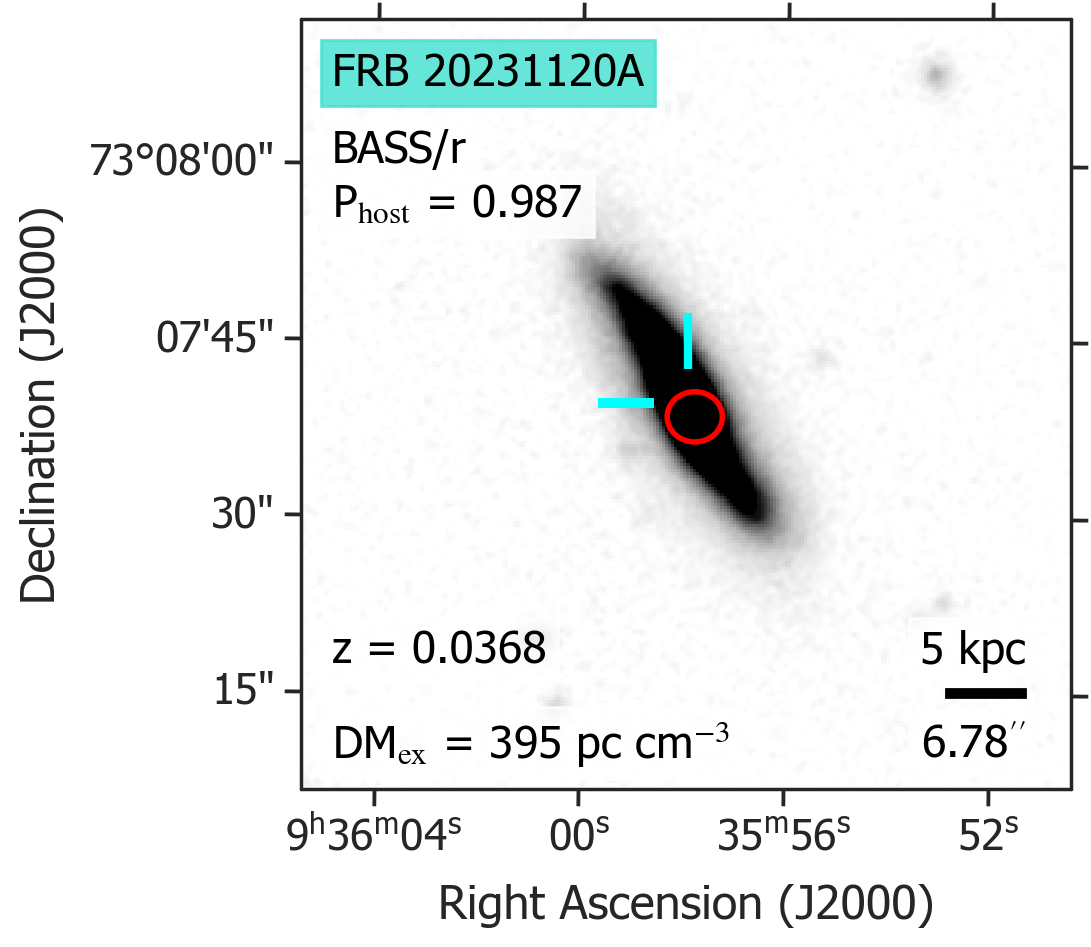

In [3]:
data = fits.open(img_loc)[1].data
hdr = fits.open(img_loc)[1].header
wcs = WCS(hdr)
x0, y0 = wcs.world_to_pixel(host_pos)

cutout = Cutout2D(data, position=(x0, y0), size=(cutout_size, cutout_size), wcs=wcs)
data = cutout.data
gauss_kernel = Gaussian2DKernel(gauss_kernel_width/pixel_scales[dsa_frbs["P_host"][0].split(" ")[0]])
data = convolve(data, gauss_kernel)
wcs2 = cutout.wcs

z = dsa_frbs["redshift"][0]
DM = get_DMexgal(frb)

plt.figure(figsize=(6, 5), frameon=False)
ax2 = plt.subplot(projection=wcs)
ax2.set_xlabel('Right Ascension (J2000)')
ax2.set_ylabel('Declination (J2000)')

_, median, sigma = sigma_clipped_stats(data)
ax2.imshow(data, vmin = median-0*sigma, vmax=median+60*sigma, origin='lower', cmap="gray_r")

ax2.text(.04, .93, '{}'.format(dsa_frbs["FRB_TNS_name"][0]), 
         color="black", ha='left', va='center',
         bbox=dict(facecolor='turquoise', edgecolor='turquoise', alpha=0.8), transform=ax2.transAxes, fontsize=fontsize)

ax2.text(.04, .83, dsa_frbs["P_host"][0].split(" ")[0], 
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.8), color="black", ha='left', va='center', transform=ax2.transAxes, fontsize=fontsize)
ax2.text(.04, .76, "P{} = {}".format(r"$_{{\mathrm{host}}}$", dsa_frbs["P_host"][0].split(" ")[1]), 
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.8), color="black", ha='left', va='center', transform=ax2.transAxes, fontsize=fontsize)

ax2.text(.04, .18, 'z = {}'.format(round(float(z), 4)), 
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.8), color="black", ha='left', va='center', transform=ax2.transAxes, fontsize=fontsize)
ax2.text(.04, .06, 'DM{} = {} pc cm{}'.format(r"$_{{\mathrm{ex}}}$", int(DM), r"$^{-3}$"), 
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.8), color="black", ha='left', va='center', transform=ax2.transAxes, fontsize=fontsize)

physical_size_in_pix = (physical_size/(cosmo.angular_diameter_distance(z).value*1e3))*(180/3.14)*3600/(pixel_scales[dsa_frbs["P_host"][0].split(" ")[0]]*cutout_size)
physical_size_in_arcsec = physical_size_in_pix*cutout_size*pixel_scales[dsa_frbs["P_host"][0].split(" ")[0]]

ax2.text(0.94, 0.18, '{} kpc'.format(physical_size), 
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8), color="black", ha='right', va='center', transform=ax2.transAxes, fontsize=fontsize)
ax2.text(0.94, 0.06, '{}{}'.format(round(physical_size_in_arcsec, 2), r"$^{\prime\prime}$"), 
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.8), color="black", ha='right', va='center', transform=ax2.transAxes, fontsize=fontsize)

r = Rectangle((0.94, 0.12), 
              0.01, physical_size_in_pix,
              fill=True, alpha=1, angle=90, 
              edgecolor='black', facecolor='black', 
              transform=ax2.transAxes)
ax2.add_patch(r)

pos = position0[0]
x1, y1 = wcs2.world_to_pixel(pos)
aper = EllipticalAperture((x1, y1), 
                          e_ra*2.15/pixel_scales[dsa_frbs["P_host"][0].split(" ")[0]], 
                          e_dec*2.15/pixel_scales[dsa_frbs["P_host"][0].split(" ")[0]], 
                          0)
aper.plot(color='red', linewidth=2)

ra_stars = []
dec_stars = []

for i in range(len(ra_stars)):
    pos = SkyCoord(ra_stars[i], dec_stars[i], unit=(u.deg, u.deg), frame='icrs')
    x1, y1 = wcs2.world_to_pixel(pos)
    plt.scatter(x1, y1, marker='x', color="yellow", s=50, lw=0.75)

plt.scatter((cutout_size)/2, (cutout_size+40)/2, marker='|', s=400, color="cyan", lw=3)
plt.scatter((cutout_size-40)/2, (cutout_size)/2, marker='_', s=400, color="cyan", lw=3)

